In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.conv_learner import *
from planet import *
import operator

In [6]:
project_name = 'planet-understanding-the-amazon-from-space'

In [7]:
PATH='/home/paperspace/data/planet/'

In [8]:
arch=resnet50
size=64
bs=64
metrics=[f2]

In [9]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [10]:
label_csv = f'{PATH}train_v2.csv'

In [11]:
no_of_rows = len(list(open(label_csv)))-1

In [12]:
val_idxs = get_cv_idxs(no_of_rows)

In [13]:
print(val_idxs.shape)
val_idxs

(8095,)


array([34602, 11243, 14499, ..., 13041, 22865, 25088])

In [14]:
label_df = pd.read_csv(label_csv)

In [15]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [16]:
label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)[:10]

,image_name
tags,
clear primary,13636
partly_cloudy primary,3630
cloudy,2089
clear primary water,1850
agriculture clear primary road,1680
agriculture clear primary,1626
haze primary,1471
agriculture clear cultivation primary,1170
agriculture clear habitation primary road,1125


In [17]:
data = get_data(size)

In [18]:
x, y = next(iter(data.val_dl))

In [19]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [20]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

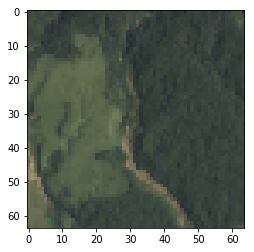

In [21]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

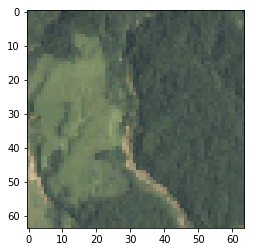

In [22]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] * 1.3 ) # TIP : Multiply by a value if the image is too hazy

In [23]:
data = get_data(size)

In [24]:
data = data.resize(int(size*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

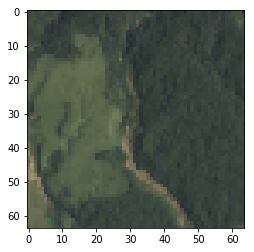

In [25]:
plt.imshow(data.val_ds.denorm( to_np(x) )[0] )

## Train model

In [26]:
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

In [27]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.222245   0.356441   0.779842  



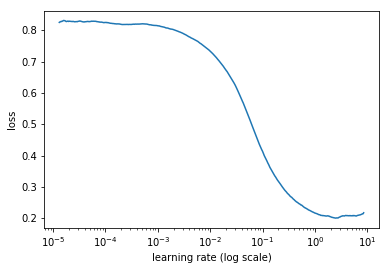

In [28]:
learn.sched.plot()

In [29]:
learning_rate = 0.2

In [30]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.140565   0.134362   0.88035   
    1      0.13938    0.128692   0.88727                     
    2      0.135783   0.125671   0.890369                    
    3      0.136448   0.125735   0.888753                    
    4      0.131846   0.123653   0.892516                    
    5      0.129778   0.122066   0.893229                    
    6      0.128102   0.121428   0.895032                    

CPU times: user 5min 50s, sys: 1min 53s, total: 7min 43s
Wall time: 5min 23s


[0.1214284, 0.8950321378872036]

##### As sat images are not part of imagnet, we divide by smaller numbers as we want to train the entire network from scratch. Well kind of, we initially use the weights from imagnet model as something is better than nothing and also, imagnet initial layers actually detect basic structures like edges etc.

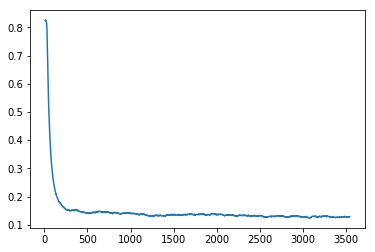

In [31]:
learn.sched.plot_loss()

In [54]:
learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate]) 

In [55]:
learn.unfreeze()

In [56]:
%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.11452    0.10682    0.907816  
    1      0.110477   0.102186   0.914154                    
    2      0.10552    0.098082   0.918442                    
    3      0.109006   0.104773   0.908302                    
    4      0.102628   0.100106   0.916582                    
    5      0.097605   0.095703   0.920222                     
    6      0.094115   0.095546   0.919903                     

CPU times: user 11min 35s, sys: 4min 8s, total: 15min 44s
Wall time: 13min 22s


[0.09554622, 0.9199029785189883]

In [59]:
%time learn.save(f'{project_name}_last_layer_{size}')

CPU times: user 20 ms, sys: 84 ms, total: 104 ms
Wall time: 101 ms


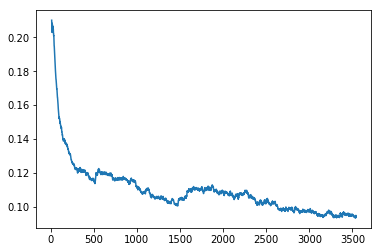

In [60]:
learn.sched.plot_loss()

### Increase pic size

In [61]:
size = 128

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.097945   0.092566   0.920806  
    1      0.093414   0.091352   0.922667                     
    2      0.093144   0.090884   0.922788                     
    3      0.092269   0.090649   0.921729                     
    4      0.091856   0.089895   0.924178                     
    5      0.091597   0.089068   0.92526                      
    6      0.091841   0.089778   0.924582                     

CPU times: user 21min 8s, sys: 3min 41s, total: 24min 50s
Wall time: 11min 25s


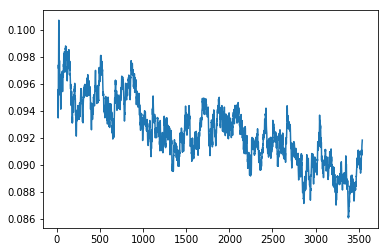

In [62]:
learn.set_data(get_data(size))
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.09606    0.088134   0.925503  
    1      0.094795   0.089023   0.925505                     
    2      0.089709   0.08484    0.929667                     
    3      0.094364   0.094098   0.919708                     
    4      0.08949    0.087064   0.9275                       
    5      0.085296   0.084161   0.929881                     
    6      0.080077   0.083528   0.930335                     

CPU times: user 35min 24s, sys: 8min 12s, total: 43min 36s
Wall time: 30min 33s


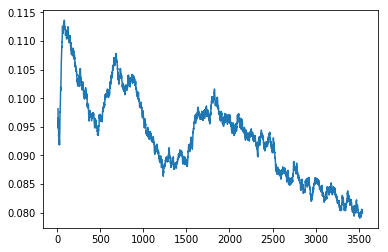

In [63]:
learn.unfreeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2, metrics=metrics)
learn.sched.plot_loss()
learn.save(f'{project_name}_last_layer_{size}')

In [32]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [33]:
print(multi_preds.shape)
print(preds.shape)
print(y.shape)

(5, 8095, 17)
(8095, 17)
(8095, 17)


In [34]:
preds[0]

array([0.848  , 0.0015 , 0.01953, 0.00041, 0.00028, 0.98738, 0.00008, 0.00121, 0.12843, 0.14272, 0.00128,
       0.01301, 0.99821, 0.53993, 0.00162, 0.00807, 0.61423], dtype=float32)

In [35]:
y[0]

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32)

In [36]:
f2(preds,y)

0.8975933701679389

In [37]:
test_multi_preds, test_y = learn.TTA(is_test=True) # doesn't return test_y for test set as the label is to be predicted!
test_preds = np.mean(test_multi_preds, 0)

In [38]:
print(test_multi_preds.shape)
print(test_preds.shape)
print(test_y.shape)

(5, 40669, 17)
(40669, 17)
(40669, 1)


In [39]:
test_y.max()

0.0

In [40]:
test_preds[0]

array([0.88708, 0.01381, 0.02813, 0.00088, 0.00137, 0.18902, 0.00114, 0.00433, 0.35736, 0.20007, 0.00728,
       0.82546, 0.99657, 0.45668, 0.00247, 0.01833, 0.13517], dtype=float32)

In [159]:
test_preds[240]

array([0.00794, 0.00035, 0.00131, 0.00093, 0.00033, 0.31998, 0.16492, 0.00019, 0.00197, 0.00141, 0.3593 ,
       0.00094, 0.46215, 0.00679, 0.00023, 0.0002 , 0.26945], dtype=float32)

In [41]:
test_probs = np.round(test_preds)

In [42]:
test_probs.shape

(40669, 17)

In [118]:
test_probs[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [130]:
print(test_probs[240]) # all zeros?

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [44]:
f2(test_preds, test_probs)

0.9410005668469361

In [143]:
#def get_test_classes(probs, classes):
#    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
#    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter
    #return operator.itemgetter(*prob_idxs)(classes) 

In [195]:
def get_test_classes(probs, classes):
    prob_idxs = np.argwhere(probs==1) # Indexs of 1's in every row of probs ([0 1 0 1 0 1 0])
    prob_idxs = prob_idxs.flatten().tolist() # Convert the o/p to a list after flatting it as required by itemgetter
    #print(prob_idxs)
    all_probs_zero = 0
    if not prob_idxs:
        all_probs_zero =+ 1
        prob_idxs = [10]  # default to haze
    print("All 0 probs : {}".format(all_probs_zero))
    #return operator.itemgetter(*(np.argwhere(probs==1)).flatten().tolist())(classes)    
    return operator.itemgetter(*prob_idxs)(classes) 

In [219]:
a = get_test_classes(test_probs[4], learn.data.classes)
print(type(a))
print(len(a))
a

All 0 probs : 0
<class 'str'>
6


'cloudy'

In [197]:
#operator.itemgetter(a)(learn.data.classes) 
test_classes = [' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]
#[print( ' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) ) ) for a in test_probs[230:250]]
#test_classes = [' '.join( operator.itemgetter(*(np.argwhere(a==1)).flatten().tolist())(learn.data.classes) )  for a in test_probs]

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

In [197]:

test_classes = [ ' '.join( get_test_classes(probs, learn.data.classes) ) for probs in test_probs]


All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 1
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 probs : 0
All 0 pr

In [198]:
test_classes[:3]
#print(len(test_classes))

['agriculture partly_cloudy primary',
 'clear cultivation primary',
 'agriculture clear primary water']

In [199]:
fn = PATH + get_data(224).test_ds.fnames[240]
fn

'/home/paperspace/data/planet/test-jpg/test_32545.jpg'

In [200]:
fnames = [f[9:-4] for f in learn.data.test_ds.fnames]
len(fnames)

40669

In [201]:
fnames[240]

'test_32545'

In [209]:
subm = np.stack([fnames, test_classes], axis=1)
subm[:3]

array([['test_25202', 'agriculture partly_cloudy primary'],
       ['test_5717', 'clear cultivation primary'],
       ['test_40598', 'agriculture clear primary water']], dtype='<U62')

In [210]:
test_df = pd.DataFrame(subm)

In [211]:
test_df.head()

,0,1
0,test_25202,agriculture partly_cloudy primary
1,test_5717,clear cultivation primary
2,test_40598,agriculture clear primary water
3,test_35442,agriculture clear primary water
4,test_22859,c l o u d y


In [212]:
#test_df.insert(0, 'image_name', fnames )

# Submit to kaggle

In [213]:
!pwd

/home/paperspace/fastai/courses/dl1


In [214]:
now = datetime.datetime.now()
submission_file_name = f'{project_name}-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, subm, fmt='%s,%s', header='file,species', comments='')

In [215]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/planet-understanding-the-amazon-from-space-2018-01-31 02:21:52.631479.csv